In [1]:
# Core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
from imblearn.over_sampling import SMOTE
import itertools
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import time
import optuna 
import imblearn
from imblearn.under_sampling import NearMiss
from numpy import percentile



# Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
#from sklearn.metrics import roc_auc_score, plot_roc_curve, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import IsolationForest
from sklearn.feature_selection import RFE
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import LocalOutlierFactor


# Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score


# Imputer

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import make_scorer, log_loss
from sklearn.preprocessing import PowerTransformer

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")
original = pd.read_csv("cirrhosis.csv")

# Data Prepare

In [3]:
train = train.rename(columns = {"id":"ID"})
train["is_original"] = 0
original["is_original"] = 1

In [4]:
train_concat = pd.concat([train,original], axis = 0)
train_concat = train_concat.reset_index(drop = True)
train_concat

,ID,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,...,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status,is_original
0,0,999,D-penicillamine,21532,M,N,N,N,N,2.3,...,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D,0
1,1,2574,Placebo,19237,F,N,N,N,N,0.9,...,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C,0
2,2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,...,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D,0
3,3,2576,Placebo,18460,F,N,N,N,N,0.6,...,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C,0
4,4,788,Placebo,16658,F,N,Y,N,N,1.1,...,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8318,414,681,NaN,24472,F,NaN,NaN,NaN,N,1.2,...,2.96,NaN,NaN,NaN,NaN,174.0,10.9,3.0,D,1
8319,415,1103,NaN,14245,F,NaN,NaN,NaN,N,0.9,...,3.83,NaN,NaN,NaN,NaN,180.0,11.2,4.0,C,1
8320,416,1055,NaN,20819,F,NaN,NaN,NaN,N,1.6,...,3.42,NaN,NaN,NaN,NaN,143.0,9.9,3.0,C,1
8321,417,691,NaN,21185,F,NaN,NaN,NaN,N,0.8,...,3.75,NaN,NaN,NaN,NaN,269.0,10.4,3.0,C,1


In [19]:
# Number of Missing Values
train_concat.isna().sum()

ID                 0
N_Days             0
Drug             106
Age                0
Sex                0
Ascites          106
Hepatomegaly     106
Spiders          106
Edema              0
Bilirubin          0
Cholesterol      134
Albumin            0
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              6
Status             0
is_original        0
dtype: int64

In [20]:
# Number of unique values
train_concat.nunique()


ID               7905
N_Days            495
Drug                2
Age               397
Sex                 2
Ascites             2
Hepatomegaly        2
Spiders             2
Edema               3
Bilirubin         117
Cholesterol       227
Albumin           167
Copper            171
Alk_Phos          364
SGOT              206
Tryglicerides     154
Platelets         252
Prothrombin        50
Stage               4
Status              3
is_original         2
dtype: int64

In [8]:
# Categoric columns and Numeric Columns

all_columns = train_concat.columns.tolist()

categoric_columns = ["Drug","Sex","Ascites","Hepatomegaly","Spiders","Edema","Stage","is_original","Status"]
numeric_columns = [col for col in all_columns if col not in categoric_columns]

categoric_columns = categoric_columns[:-1]
numeric_columns = numeric_columns[1:]

print("Categoric Columns")
print(categoric_columns)
print("                   ")
print("Numeric Columns")
print(numeric_columns)


Categoric Columns
['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Stage', 'is_original']
                   
Numeric Columns
['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']


In [9]:
# Base Model

X = train.drop(["ID","Status"], axis = 1)
y = train["Status"]


categoric_transform = Pipeline(steps = [("ohe",OneHotEncoder())])
numeric_transform = Pipeline(steps = [("normalizer",StandardScaler())])

transformer = ColumnTransformer(transformers = [("cat",categoric_transform,categoric_columns),
                                               ("num",numeric_transform,numeric_columns)])

pipeline = Pipeline(steps = [("transformer",transformer),
                            ("model", CatBoostClassifier(verbose = 0))])





cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 42)
score = cross_val_score(pipeline, X, y, cv = cv, scoring = "accuracy").mean()

print("Base Score:", score)

Base Score: 0.8246248673099797


In [18]:
# Handle the missing values 

from sklearn.impute import SimpleImputer
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import make_scorer, log_loss

# log_loss'u kullanarak scorer oluşturma
log_loss_scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)


# Imputation for categoric variables
cat_imputer = SimpleImputer(strategy = "most_frequent")
cat_imputer.fit(train_concat[categoric_columns])
train_concat[categoric_columns] = cat_imputer.transform(train_concat[categoric_columns])

# Imputation for numeric variables

strategy = ["mean","median","most_frequent","constant"]
strategy_results = pd.DataFrame({"strategy":[i for i in strategy],
                                "result":np.zeros(len(strategy)),
                                "result_st":np.zeros(len(strategy)),
                                "result_pt":np.zeros(len(strategy))})

# Try Every Strategy for numeric columns 

a = 0

X = train_concat.drop(["Status"], axis = 1)
y = train_concat["Status"]

for s in strategy:
    
    numeric_transform = Pipeline(steps = [("i",SimpleImputer(strategy = s))])
    categoric_transform = Pipeline(steps = [("ohe", OneHotEncoder())])
    
    preprocessor_1 = ColumnTransformer(transformers = [("num",numeric_transform, numeric_columns),
                                                    ("cat",categoric_transform, categoric_columns)])
    
    pipeline1 = Pipeline(steps = [("pre",preprocessor_1),
                                ("model",CatBoostClassifier(verbose = 0))])
    
    cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 2, random_state = 42)
    score1 = cross_val_score(pipeline1, X,y, cv = cv , scoring ="accuracy").mean()
    strategy_results.iloc[a,1] = score1
    
    ##
    
    numeric_transform_2 = Pipeline(steps = [("std",StandardScaler()),("i",SimpleImputer(strategy = s))])
    categoric_transform_2 = Pipeline(steps = [("ohe", OneHotEncoder())])
    
    preprocessor_2 = ColumnTransformer(transformers = [("num",numeric_transform_2, numeric_columns),
                                                    ("cat",categoric_transform_2, categoric_columns)])
    
    pipeline2 = Pipeline(steps = [("pre",preprocessor_2),
                                ("model",CatBoostClassifier(verbose = 0))])
    
    cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 2, random_state = 42)
    score2 = cross_val_score(pipeline2, X,y, cv = cv , scoring ="accuracy").mean()
    strategy_results.iloc[a,2] = score2

    
    ##
    
    numeric_transform_3 = Pipeline(steps = [("sca",MinMaxScaler(feature_range = (1,2))),
        ("std",PowerTransformer(method = "box-cox")),("i",SimpleImputer(strategy = s))])
    categoric_transform_3 = Pipeline(steps = [("ohe", OneHotEncoder())])
    
    preprocessor_3 = ColumnTransformer(transformers = [("num",numeric_transform_3, numeric_columns),
                                                    ("cat",categoric_transform_3, categoric_columns)])
    
    pipeline3 = Pipeline(steps = [("pre",preprocessor_3),
                                ("model",CatBoostClassifier(verbose = 0))])
    
    cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 2, random_state = 42)
    score3 = cross_val_score(pipeline3, X,y, cv = cv , scoring ="accuracy").mean()
    strategy_results.iloc[a,3] = score3 
    
    a+=1


strategy_results

,strategy,result,result_st,result_pt
0,mean,0.826565,0.826625,0.826865
1,median,0.826084,0.826084,0.826084
2,most_frequent,0.827225,0.827225,0.827225
3,constant,0.825724,0.826625,0.826865


In [85]:
# Iterative Imputation

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import make_scorer, log_loss
from sklearn.preprocessing import PowerTransformer



strategies = ['ascending', 'descending', 'roman', 'arabic', 'random']

for s in strategies:
    for i in range(1,5):
        for j in range(1,10):

            imputer = IterativeImputer(estimator = BayesianRidge(), n_nearest_features = i, max_iter = j, imputation_order = s)

            # Impute the categoricals with the most frequent
            cat_imputer = SimpleImputer(strategy = "most_frequent")
            cat_imputer.fit(train_concat[categoric_columns])
            train_concat[categoric_columns] = cat_imputer.transform(train_concat[categoric_columns])

            # Define X ,y
            X = train_concat.drop(["Status"], axis = 1)

            label_encoder = LabelEncoder()

            train_concat["Status"] = label_encoder.fit_transform(train_concat["Status"])
            y = train_concat["Status"]


            # Categorical Transformer
            categorical_transformer = Pipeline(steps=[("ohe", OneHotEncoder(drop="if_binary", handle_unknown="ignore", sparse=False))])
            # Numerical Transformer
            numerical_transformer = Pipeline(steps = [("s",PowerTransformer(method = "box-cox")),("i",imputer)])
            # Transformer
            transformer = ColumnTransformer(transformers = [("cat",categorical_transformer,categoric_columns),
                                                           ("num",numerical_transformer,numeric_columns)])

            # Pipeline

            pipeline = Pipeline(steps = [("t",transformer),
                                         ("m",LGBMClassifier(verbose = 0))])



            cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 42)
            score = cross_val_score(pipeline,X,y,cv = cv, scoring = "accuracy").mean()

            print("Iterative Imputation for strategy:",s,", for n:",i,"and for max_iter:",j,"the Score",score)



Iterative Imputation for strategy: ascending , for n: 1 and for max_iter: 1 the Score 0.8309909540739373
Iterative Imputation for strategy: ascending , for n: 1 and for max_iter: 2 the Score 0.8327935020161912
Iterative Imputation for strategy: ascending , for n: 1 and for max_iter: 3 the Score 0.8306302328623758
Iterative Imputation for strategy: ascending , for n: 1 and for max_iter: 4 the Score 0.8306310985932835
Iterative Imputation for strategy: ascending , for n: 1 and for max_iter: 5 the Score 0.8317920437405734
Iterative Imputation for strategy: ascending , for n: 1 and for max_iter: 6 the Score 0.830590216855973
Iterative Imputation for strategy: ascending , for n: 1 and for max_iter: 7 the Score 0.8314310820482038
Iterative Imputation for strategy: ascending , for n: 1 and for max_iter: 8 the Score 0.8312311463046758
Iterative Imputation for strategy: ascending , for n: 1 and for max_iter: 9 the Score 0.8330735178686859
Iterative Imputation for strategy: ascending , for n: 2 

In [76]:
# KNN Imputer
from sklearn.impute import KNNImputer

knn_table = pd.DataFrame({"neighbors":np.zeros(10),
                         "score":np.zeros(10)})

a = 0

for i in range (11,21):
    imputer = KNNImputer(n_neighbors = i, weights = "uniform") # Weightslerle oynanıyor mu bak

    # Impute the categoricals with the most frequent
    cat_imputer = SimpleImputer(strategy = "most_frequent")
    cat_imputer.fit(train_concat[categoric_columns])
    train_concat[categoric_columns] = cat_imputer.transform(train_concat[categoric_columns])


    X = train_concat.drop(["Status"], axis = 1)
    y = train_concat["Status"]


    categoric_transform = Pipeline(steps = [("ohe",OneHotEncoder(drop = "if_binary"))])
    
    #numeric_transform = Pipeline(steps = [("n",PowerTransformer(method = "box-cox")),("i",imputer)])
    
    numeric_transform = Pipeline(steps = [("n",PowerTransformer(method = "box-cox")),
                                          ("i",imputer)])

    transformer = ColumnTransformer(transformers = [("c",categoric_transform, categoric_columns),
                                                   ("n",numeric_transform,numeric_columns)])


    pipeline = Pipeline(steps = [("t",transformer),
                                ("m",LGBMClassifier(verbose = 0))]
                       )

    cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 42)
    score = cross_val_score(pipeline, X, y , cv = cv , scoring = "accuracy").mean()
    
    knn_table.iloc[a][0] = i
    knn_table.iloc[a][1] = score
    a += 1

    print("KNNImputer Score for neighbor",i,":",score)

KNNImputer Score for neighbor 11 : 0.8322323640994859
KNNImputer Score for neighbor 12 : 0.8301896239264936
KNNImputer Score for neighbor 13 : 0.8307106496444732
KNNImputer Score for neighbor 14 : 0.8310305372148861
KNNImputer Score for neighbor 15 : 0.8297488707021271
KNNImputer Score for neighbor 16 : 0.8318318673623296
KNNImputer Score for neighbor 17 : 0.8311090301505218
KNNImputer Score for neighbor 18 : 0.8330736140610092
KNNImputer Score for neighbor 19 : 0.8302303132791578
KNNImputer Score for neighbor 20 : 0.8313517233816605


In [70]:
# 1. Power Transform (box-cox)
# 2. KNNImputer n_neighbors 10
# model deneme 

models = {"CatBoostClassifier":CatBoostClassifier(verbose = 0),
          "HGBClassifier": HistGradientBoostingClassifier(verbose = 0),
          "XGBClassifer": XGBClassifier(verbose = 0),
          "LGBMClassifier": LGBMClassifier(verbose = -1),
          "RandomForestClassifier": RandomForestClassifier(verbose = 0)
    
}

model_df = pd.DataFrame({"Model":models.keys(), "accuracy":np.zeros(len(models))})

i = 0

for key, model in models.items(): 
    
    imputer = KNNImputer(n_neighbors = 18, weights = "uniform")

    # Impute the categoricals with the most frequent
    cat_imputer = SimpleImputer(strategy = "most_frequent")
    cat_imputer.fit(train_concat[categoric_columns])
    train_concat[categoric_columns] = cat_imputer.transform(train_concat[categoric_columns])


    X = train_concat.drop(["Status"], axis = 1)
    y = train_concat["Status"]


    categoric_transform = Pipeline(steps = [("ohe",OneHotEncoder(drop = "if_binary"))])
    numeric_transform = Pipeline(steps = [("n",PowerTransformer(method = "box-cox")),("i",imputer)])

    transformer = ColumnTransformer(transformers = [("c",categoric_transform, categoric_columns),
                                                    ("n",numeric_transform,numeric_columns)])

    pipeline = Pipeline(steps = [("t",transformer),
                                    ("m",model)])

    cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 42)
    score = cross_val_score(pipeline, X, y , cv = cv , scoring = "accuracy").mean()
    
    model_df.iloc[i][1] = score 
    
    i += 1
    
    print(key,"score:",score)
    
model_df
    
    

CatBoostClassifier score : 0.8278666755163603
HGBClassifier score : 0.8281869959522271
XGBClassifer score : 0.8277062267214579
LGBMClassifier score : 0.8330736140610092
RandomForestClassifier score : 0.8235015159910117


,Model,accuracy
0,CatBoostClassifier,0.0
1,HGBClassifier,0.0
2,XGBClassifer,0.0
3,LGBMClassifier,0.0
4,RandomForestClassifier,0.0


In [61]:
# Imputers

def imputer(data):
    
    # Categoric Imputation
    cat_imputer = SimpleImputer(strategy = "most_frequent")
    train_concat[categoric_columns] = cat_imputer.fit_transform(train_concat[categoric_columns])
    
    # Numeric Imputation
    scaler = StandardScaler()
    
    train_concat[numeric_columns] = scaler.fit_transform(train_concat[numeric_columns])
    
    num_imputer = IterativeImputer(BayesianRidge(),
                                  n_nearest_features = 2,
                                  max_iter = 6,
                                  imputation_order = "descending")
    train_concat[numeric_columns] = num_imputer.fit_transform(train_concat[numeric_columns])
    
    return train_concat
    

In [62]:
imputer(train_concat)

KeyError: "None of [Index(['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Stage',\n       'is_original'],\n      dtype='object')] are in the [columns]"

In [82]:
# Label encoder

encoder = LabelEncoder()
labels = categoric_columns[0:-2]

for l in labels:
    
    train_concat[l] =encoder.fit_transform(train_concat[l])
    
train_concat

,ID,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,...,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status,is_original
0,0,-0.936639,0,0.854662,1,0,0,0,0,-0.084728,...,-0.558257,1.152749,-0.117007,1.326887,-1.001107,1.468274,9.7,3.0,D,0
1,1,0.501845,1,0.232139,0,0,0,0,0,-0.448656,...,-0.016446,-0.282798,-0.201687,0.406744,-0.526162,1.093176,11.0,3.0,C,0
2,2,1.281823,1,-1.262458,0,0,1,1,2,0.175221,...,0.012071,0.612773,-0.417859,0.089454,-1.248079,-0.748215,11.7,4.0,D,0
3,3,0.503671,1,0.021377,0,0,0,0,0,-0.526640,...,-0.130511,-0.348649,-0.089657,-0.894147,-0.374180,0.047448,10.7,3.0,C,0
4,4,-1.129350,1,-0.467419,0,0,1,0,0,-0.396666,...,0.297234,-0.282798,-0.337912,0.216370,-0.374180,0.377079,10.6,4.0,C,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8318,414,-1.227076,1,1.652143,0,0,1,0,0,-0.370671,...,-1.670395,-0.151770,-0.043763,0.498096,-0.038916,-1.032380,10.9,3.0,D,1
8319,415,-0.841653,1,-1.121950,0,0,1,0,0,-0.448656,...,0.810529,-0.188549,-0.054601,0.047472,-0.076506,-0.964181,11.2,4.0,C,1
8320,416,-0.885493,1,0.661260,0,0,1,0,0,-0.266692,...,-0.358642,-0.109194,-0.031486,0.232108,-0.027987,-1.384745,9.9,3.0,C,1
8321,417,-1.217942,1,0.760538,0,0,1,0,0,-0.474650,...,0.582398,-0.197031,-0.056943,0.157493,-0.066123,0.047448,10.4,3.0,C,1


In [85]:
# Feature Selection

from sklearn.feature_selection import RFE

X = train_concat.drop(["ID","Status"], axis = 1)
y = train_concat["Status"]

for i in range (1,21):

    estimator = LGBMClassifier(verbose = -1)
    selector = RFE(estimator, n_features_to_select = i)

    cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 42)

    score = cross_val_score(selector,X,y,cv=cv,scoring = "accuracy").mean()

    print("n_featues:",i,"Score:",score)


n_featues: 1 Score: 0.7120865172992272
n_featues: 2 Score: 0.7710759784683104
n_featues: 3 Score: 0.7852940214547356
n_featues: 4 Score: 0.7911410718133407
n_featues: 5 Score: 0.7975486829347124
n_featues: 6 Score: 0.8040357970111122
n_featues: 7 Score: 0.808081068966048
n_featues: 8 Score: 0.8061598677932712
n_featues: 9 Score: 0.8103244182288301
n_featues: 10 Score: 0.8201760992858683
n_featues: 11 Score: 0.8294280212084835
n_featues: 12 Score: 0.8309106815803246
n_featues: 13 Score: 0.8300701049650631
n_featues: 14 Score: 0.8310307776956936
n_featues: 15 Score: 0.8328731973558654
n_featues: 16 Score: 0.832352364022532
n_featues: 17 Score: 0.8314310820482038
n_featues: 18 Score: 0.8338736456120909
n_featues: 19 Score: 0.8329130690737833
n_featues: 20 Score: 0.8329130690737833


# START

### 1. Imputers

In [9]:
# Imputers

def imputer(data):
    
    # Categoric Imputation
    cat_imputer = SimpleImputer(strategy = "most_frequent")
    train_concat[categoric_columns] = cat_imputer.fit_transform(train_concat[categoric_columns])
    
    # Numeric Imputation
    
    #train_concat[numeric_columns] = scaler.fit_transform(train_concat[numeric_columns])
    
    num_imputer = IterativeImputer(BayesianRidge(),
                                  n_nearest_features = 2,
                                  max_iter = 6,
                                  imputation_order = "descending")
    train_concat[numeric_columns] = num_imputer.fit_transform(train_concat[numeric_columns])
    
    return train_concat


In [10]:
imputer(train_concat)

,ID,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,...,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status,is_original
0,0,999.0,D-penicillamine,21532.0,M,N,N,N,N,2.3,...,3.35,172.000000,1601.000000,179.800000,63.000000,394.0,9.7,3.0,D,0
1,1,2574.0,Placebo,19237.0,F,N,N,N,N,0.9,...,3.54,63.000000,1440.000000,134.850000,88.000000,361.0,11.0,3.0,C,0
2,2,3428.0,Placebo,13727.0,F,N,Y,Y,Y,3.3,...,3.55,131.000000,1029.000000,119.350000,50.000000,199.0,11.7,4.0,D,0
3,3,2576.0,Placebo,18460.0,F,N,N,N,N,0.6,...,3.50,58.000000,1653.000000,71.300000,96.000000,269.0,10.7,3.0,C,0
4,4,788.0,Placebo,16658.0,F,N,Y,N,N,1.1,...,3.65,63.000000,1181.000000,125.550000,96.000000,298.0,10.6,4.0,C,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8318,414,681.0,Placebo,24472.0,F,N,Y,N,N,1.2,...,2.96,71.937846,1799.910466,114.294510,132.416776,174.0,10.9,3.0,D,1
8319,415,1103.0,Placebo,14245.0,F,N,Y,N,N,0.9,...,3.83,69.298516,1791.228998,113.164224,120.414355,180.0,11.2,4.0,C,1
8320,416,1055.0,Placebo,20819.0,F,N,Y,N,N,1.6,...,3.42,75.458782,1806.193493,114.311864,124.842798,143.0,9.9,3.0,C,1
8321,417,691.0,Placebo,21185.0,F,N,Y,N,N,0.8,...,3.75,68.411820,1789.568835,113.264993,124.555240,269.0,10.4,3.0,C,1


### 2. Outliers

In [11]:
print(len(train_concat))

lof = LocalOutlierFactor()
yhat = lof.fit_predict(train_concat[numeric_columns])
mask = yhat !=-1
train_concat = train_concat[mask]

print(len(train_concat))

8323
8055


###  3.Power Transform

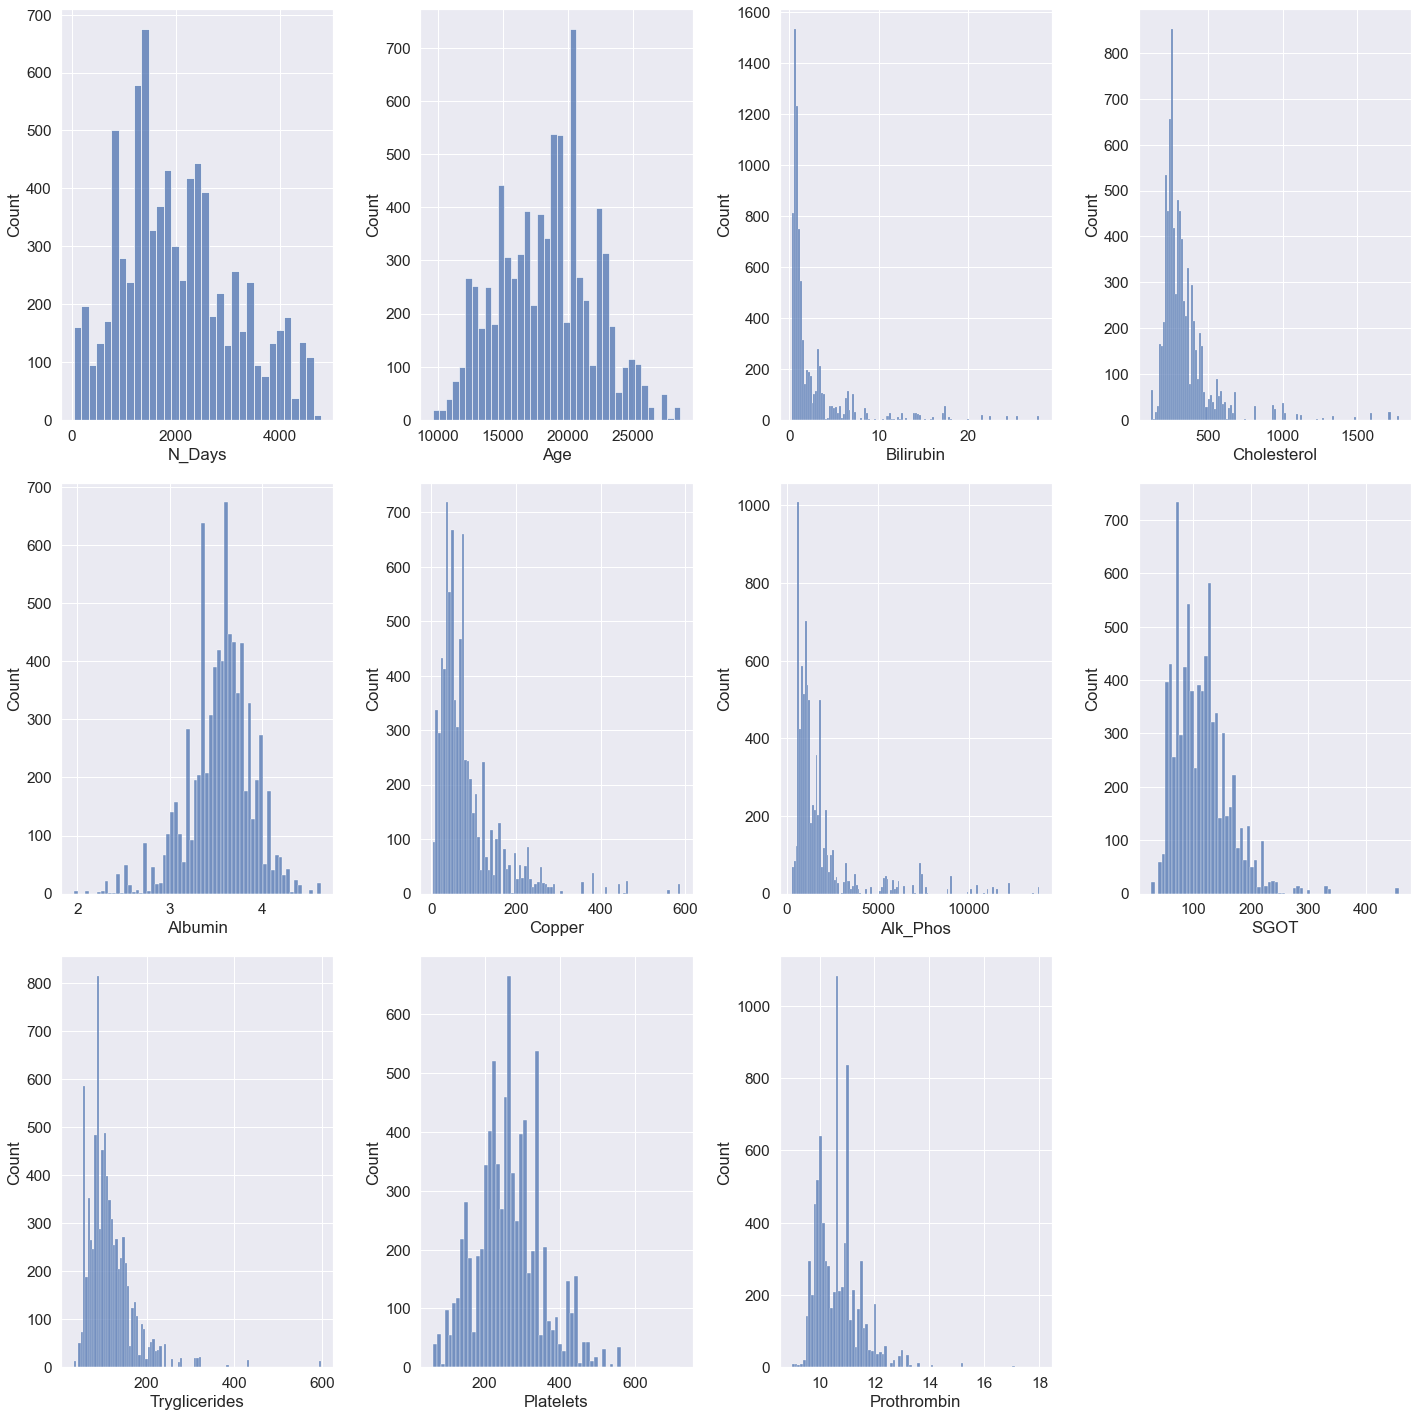

In [12]:
# Before Power Transform

fig,ax = plt.subplots(3,4, figsize = (20,20))

ax = ax.flatten()
for i, columns in enumerate(numeric_columns):
    sns.histplot(train_concat[columns], ax = ax[i])
    
    
for j in range(i + 1, len(ax)):
    ax[j].axis('off')
    
plt.tight_layout()

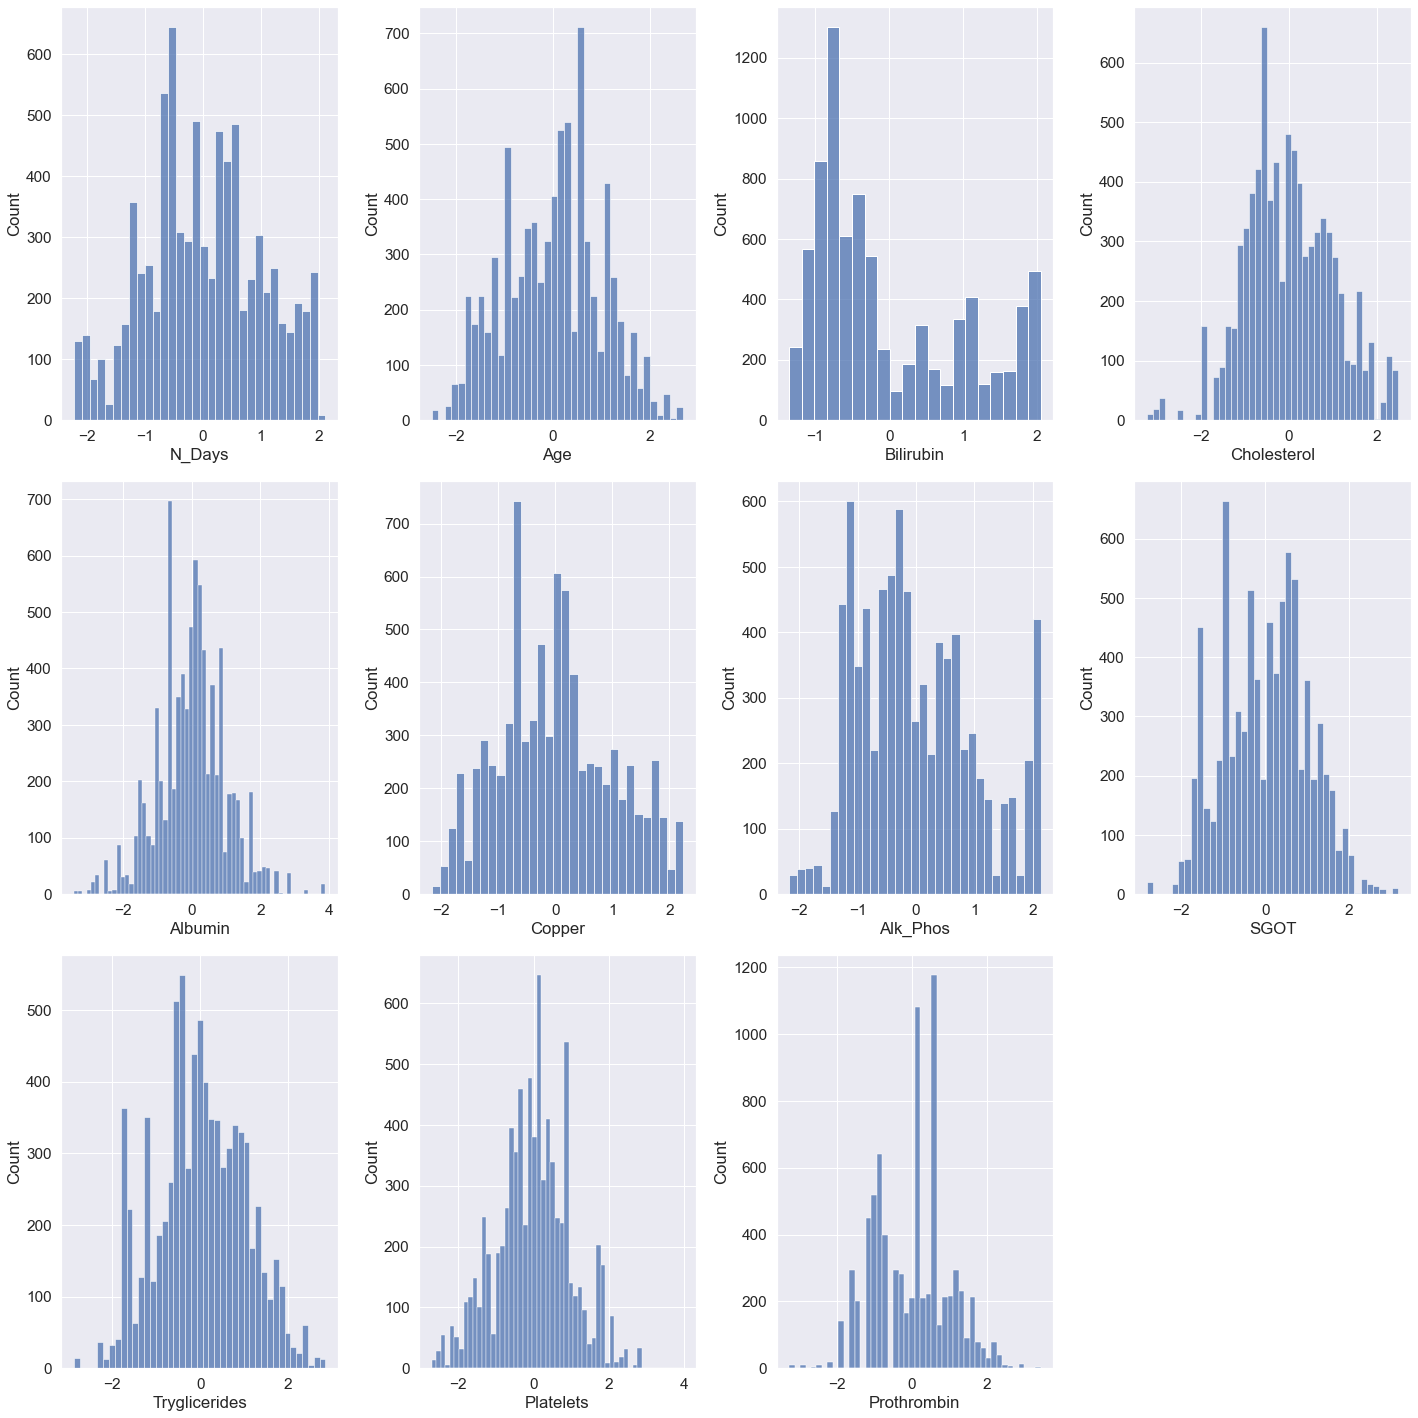

In [13]:
scaler = MinMaxScaler(feature_range = (1,2))
transformer = PowerTransformer(method = "box-cox")
train_concat_transformed = train_concat.copy()

train_concat_transformed[numeric_columns] = scaler.fit_transform(train_concat_transformed[numeric_columns])
train_concat_transformed[numeric_columns] = transformer.fit_transform(train_concat_transformed[numeric_columns])

fig,ax = plt.subplots(3,4, figsize = (20,20))

ax = ax.flatten()

for i , columns in enumerate(numeric_columns):
    sns.histplot(train_concat_transformed[columns], ax = ax[i])

for j in range(i + 1, len(ax)):
    ax[j].axis('off')
    
    
plt.tight_layout()

# OHE 



In [27]:
encoder = OneHotEncoder(drop = "first")
temp_train = pd.DataFrame(encoder.fit_transform(train_concat[categoric_columns]).toarray(), columns = encoder.get_feature_names_out())

train_concat.drop(categoric_columns, axis = 1, inplace = True)
train_concat = pd.concat([train_concat,temp_train], axis = 1)

train_concat_transformed.drop(categoric_columns, axis = 1, inplace = True)
train_concat_transformed = pd.concat([train_concat_transformed,temp_train], axis = 1)

train_concat_transformed

,ID,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,...,Sex_M,Ascites_Y,Hepatomegaly_Y,Spiders_Y,Edema_S,Edema_Y,Stage_2.0,Stage_3.0,Stage_4.0,is_original_1
0,0.0,-0.965378,0.877462,0.578758,0.120282,-0.635472,1.485091,0.380582,1.370970,-1.389677,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.581506,0.267310,-0.578894,0.553992,-0.096467,-0.032454,0.184360,0.631011,-0.484733,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2.0,1.240830,-1.269982,1.061673,-0.058554,-0.066940,1.114528,-0.435145,0.310458,-1.969920,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3,3.0,0.583173,0.057024,-0.938341,-0.582233,-0.213406,-0.158742,0.439242,-0.988250,-0.243366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4.0,-1.217084,-0.438469,-0.365450,0.402691,0.234804,-0.032454,-0.183866,0.443433,-0.243366,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7752,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
7757,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
7807,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
7867,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0


### 4. Prepare Test Set

In [14]:
test["is_original"] = 0

scaler = MinMaxScaler(feature_range = (1,2))
transformer = PowerTransformer(method = "box-cox")
test_transformed = test.copy()

test_transformed[numeric_columns] = scaler.fit_transform(test_transformed[numeric_columns])
test_transformed[numeric_columns] = transformer.fit_transform(test_transformed[numeric_columns])

# OHE

#encoder = OneHotEncoder(drop = "first")

#temp_test = pd.DataFrame(encoder.fit_transform(test_transformed[categoric_columns]).toarray(), columns = encoder.get_feature_names_out())

#test_transformed.drop(categoric_columns, axis = 1, inplace = True)
#test_transformed = pd.concat([test_transformed,temp_test], axis = 1)
#test_transformed["is_original"] = 0


for i in categoric_columns:
    test_transformed[i] = test_transformed[i].astype("str")
    
for i in categoric_columns:
    test[i] = test[i].astype("str")





In [15]:
for i in categoric_columns:
    train_concat[i] = train_concat[i].astype("str")
    
for i in categoric_columns:
    train_concat_transformed[i] = train_concat_transformed[i].astype("str")



### 5.Model

In [71]:
X = train_concat_transformed.drop(["ID","Status"],axis = 1)
y = train_concat_transformed["Status"]
X_test = test_transformed.drop("id", axis = 1)

model = CatBoostClassifier(verbose = 0, cat_features = categoric_columns)

model.fit(X,y)


y_pred = model.predict_proba(X_test)

### 5. Optuna

In [99]:
def catboost(trial):
    
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),  # Number of trees
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
        'random_strength': trial.suggest_loguniform('random_strength', 1e-3, 10.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'verbose': False  # Suppress CatBoost output
    }

    
    
    model = CatBoostClassifier(**params)
    cv = RepeatedStratifiedKFold(n_repeats = 2, n_splits = 5, random_state = 42)
    
    # transformers
    
    cat_transform = Pipeline(steps = [("i",SimpleImputer(strategy = "most_frequent")),
                                     ("ohe",OneHotEncoder(drop = "if_binary"))])
    
    numeric_transform = Pipeline(steps = [("std",MinMaxScaler(feature_range = (1,2))),
                                          ("pt", PowerTransformer(method = "box-cox")),
                                         ("imp", IterativeImputer(estimator = BayesianRidge(),
                                                                 n_nearest_features = 2,
                                                                 max_iter = 6, imputation_order = "ascending"))])
    
    column_transformer = ColumnTransformer(transformers = [("cat",cat_transform,categoric_columns),
                                                           ("num", numeric_transform, numeric_columns)])
    
    pipeline = Pipeline(steps = [("ct",column_transformer),
                                ("model", model)])
    
    
    score = cross_val_score(pipeline,X,y, cv = cv, scoring = "accuracy").mean()
    
    return score
    
cb_study = optuna.create_study(direction = "maximize")
cb_study.optimize(catboost, n_trials = 50)

best_params = cb_study.best_params


[I 2023-12-21 18:21:36,997] A new study created in memory with name: no-name-58672d6f-f41b-411a-bc9d-bc244046b08b
[I 2023-12-21 18:23:43,332] Trial 0 finished with value: 0.8171938164125663 and parameters: {'iterations': 660, 'learning_rate': 0.0020202946736736145, 'depth': 9, 'l2_leaf_reg': 0.014186045898266992, 'random_strength': 0.006596444691074475, 'border_count': 39}. Best is trial 0 with value: 0.8171938164125663.
[I 2023-12-21 18:24:00,261] Trial 1 finished with value: 0.807882558038808 and parameters: {'iterations': 143, 'learning_rate': 0.004959262586494228, 'depth': 6, 'l2_leaf_reg': 0.009403050039897918, 'random_strength': 0.5471458457482887, 'border_count': 118}. Best is trial 0 with value: 0.8171938164125663.
[I 2023-12-21 18:25:02,876] Trial 2 finished with value: 0.8304097366597366 and parameters: {'iterations': 512, 'learning_rate': 0.03646547559043634, 'depth': 8, 'l2_leaf_reg': 0.3197063916630119, 'random_strength': 0.012085926602206337, 'border_count': 66}. Best is 

In [72]:
test_copy = test.copy()
submission = sample_submission.copy()

for i in range (len(y_pred)):
        submission["Status_C"][i] = y_pred[i][0]
        submission["Status_CL"][i] = y_pred[i][1]
        submission["Status_D"][i] = y_pred[i][2]        
    


submission.to_csv("submission.csv", index = False)
print("Succesfull")

Succesfull


In [73]:
submission

,id,Status_C,Status_CL,Status_D
0,7905,0.333858,0.017478,0.648664
1,7906,0.386686,0.242228,0.371086
2,7907,0.017307,0.015246,0.967448
3,7908,0.947336,0.001913,0.050751
4,7909,0.922726,0.017002,0.060272
...,...,...,...,...
5266,13171,0.905817,0.043199,0.050984
5267,13172,0.990321,0.000579,0.009100
5268,13173,0.905293,0.012391,0.082316
5269,13174,0.992701,0.004596,0.002703
